In [1]:
# analyzing LOCALLY
import sys
import os
import torch
from pathlib import Path

def get_project_info() -> Path:
  current = Path.cwd().resolve()
  root = current
  for parent in [current, *current.parents]:
    if (parent / "toy_transformers").exists():
      root = parent
      break
  return root, current

if 'ROOT_DIR' not in globals():
	ROOT_DIR, EXPERIMENT_DIR = get_project_info()
	if str(ROOT_DIR) not in sys.path:
		sys.path.append(str(ROOT_DIR))
	if Path.cwd() != ROOT_DIR:
		os.chdir(ROOT_DIR)

from toy_transformers.models import gptv3
from toy_transformers import tokenization
from toy_transformers import checkpoint

In [2]:
VOCAB_SIZE = 4096
BATCH_SIZE = 16
GRAD_ACCUM_STEPS = 2
MODE = tokenization.TokenizationMode.STR
DEVICE = "mps"

MAX_LR = 3e-4
MIN_LR = 3e-5
WARMUP_STEPS = 500
NUM_EPOCHS = 10

EVAL_INTERVAL = 100
EVAL_BATCHES = 20
LOG_INTERVAL = 10

config = gptv3.GPTv3Config(
	vocab_size=VOCAB_SIZE,
	block_size=512,
	device=DEVICE,
	n_heads=8,
	n_embed=512,
	n_layers=8
)

In [3]:
vocab_path = EXPERIMENT_DIR / f"data/vocab_{VOCAB_SIZE}.json"
vocab = tokenization.Vocabulary.load(vocab_path)

In [4]:
CKPT_DIR: Path = EXPERIMENT_DIR / "checkpoints"

torch.set_float32_matmul_precision("medium")
m = gptv3.LanguageModel(config).to(device=DEVICE)
m.compile()

loaded_model, _, _, metrics, _, _ = checkpoint.load(
  CKPT_DIR / "epoch-10", gptv3.LanguageModel, gptv3.GPTv3Config, device=DEVICE
)

m.load_state_dict(loaded_model.state_dict())

<All keys matched successfully>

In [13]:
prompt = "A dog was accidentally crowned King,"
idx = torch.tensor([vocab.encode(prompt)], dtype=torch.long, device=DEVICE)
print(prompt, end="", flush=True)
for token in m.generate(idx, max_new_tokens=300, temperature=1.0, topk=40):
	print(vocab.decode([token.item()])[0], end="", flush=True)
print()

A dog was accidentally crowned King, and there was a pretty little dog crowned with red and white striped coats, and yellow coats, as well as a pair of big, round bells on either side. It was a very pretty animal to walk about where the children did, and to hold their hands, so the children could hear him whizzing about where they were standing.

"Stop the dog! Stop him! Stop him!" cried the Cat, trying to stop.

"Hey -- steady!" yelled a man who had just come out of the crowd, having taken a picture of the dog, and he was going to turn a somersault down the hill in his kennel, when the Cat jumped, but it was of no use, for the children could not catch him.

"What is the matter?" asked Mr. Brown. "What has happened?"

"Nothing -- I mean, he's gone," explained the Cat, but he didn't stop. The man just had to have some money.

"Say! You can't do that!" exclaimed the man. "I can't do anything with him. Hey me?"

"No indeed," said Mr. Brown, and he was as surprised as a child. "Letters hav

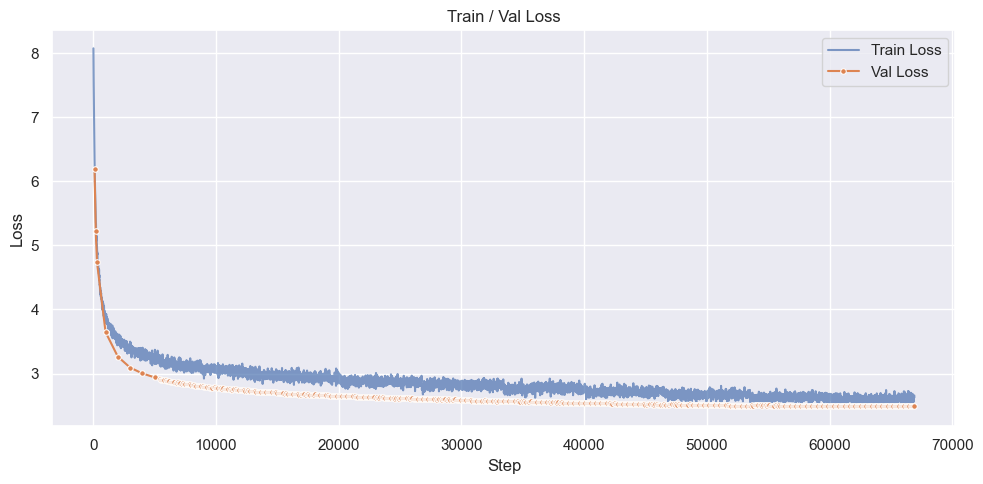

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

steps = [row["step"] for row in metrics]
train_loss = [row["train_loss"] for row in metrics]
val_steps = [row["step"] for row in metrics if "val_loss" in row]
val_loss = [row["val_loss"] for row in metrics if "val_loss" in row]

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=steps, y=train_loss, label="Train Loss", ax=ax, alpha=0.7)
sns.lineplot(x=val_steps, y=val_loss, label="Val Loss", ax=ax, marker="o", markersize=4)

ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Train / Val Loss")
plt.tight_layout()
plt.show()